### Investigate timeliness durations min and max outliers

In [12]:
%%capture

%run '../lib/libraries.ipynb'
from ..lib import utilities as util
from pyspark.sql import functions as F

In [3]:
filterDf = util.load_df('filterDf')
types = util.get_var_types()

intVars = ['student_start_datetime',
             'student_stop_datetime',
             'scored_datetime',
             'item_attempt_start_datetime_utc',
             'item_attempt_end_datetime_utc']

###### Dataframe of positive values

In [4]:
posDf = filterDf
posDf.count()

64838

###### Display problem

In [5]:
posDf.select('timeliness_duration_mins').toPandas().describe()

,timeliness_duration_mins
count,62835.000000
mean,19557.169458
std,25314.287750
min,-2751.200000
25%,2230.983333
50%,7781.166667
75%,27825.066667
max,144985.150000


- Max values over 100,000 above 3rd quartile

###### Histogram

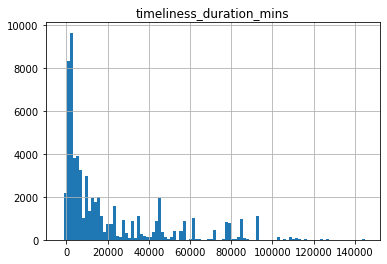

In [6]:
pdDf = posDf.select('timeliness_duration_mins').toPandas()
ax = pdDf.hist(bins=100)

- Majority between 1 and 20,000
- Hard to visualize over 90,000

###### Histogram on logarithmic scale

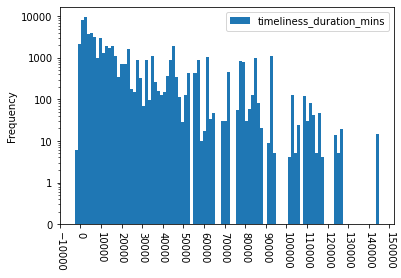

In [7]:
util.logrithmic_histogram(pdDf,10000)


- Gradually starts having gaps

###### Scatter plot of duration vs dates

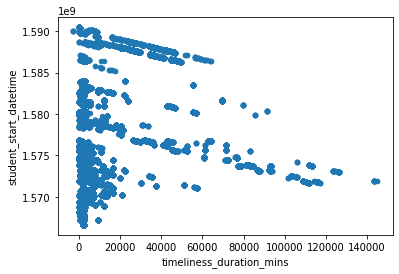

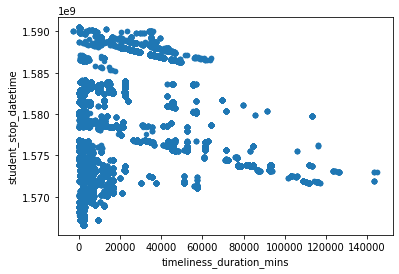

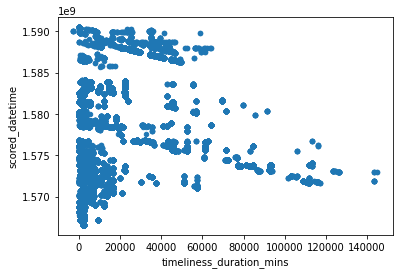

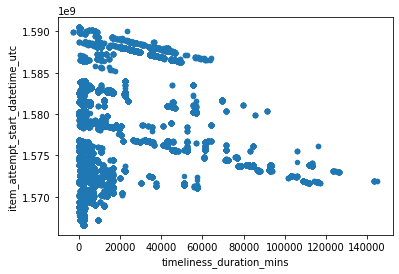

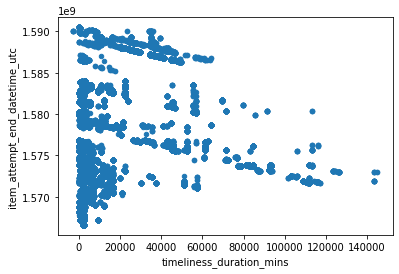

In [8]:
pdDf = posDf.select('timeliness_duration_mins', * (F.unix_timestamp(c).alias(c) for c in intVars if c in posDf.columns) ).toPandas()

for c in intVars:
    ax = pdDf.plot('timeliness_duration_mins', c, kind='scatter')

- Outliers gather at dates


###### Detect Outliers by Interquartile Range
- Formula: (Q3 + 1.5 IQR)

In [9]:
(lowFilter, highFilter, median) = util.get_iqr_filter(posDf, 'timeliness_duration_mins')
highFilter

66214.04166666666

- Outliers > 66,214

###### Create outlier dataset

In [10]:
outDf = posDf.filter( F.col('timeliness_duration_mins') > highFilter)
print ('Count', outDf.count())
print ('Percentage', round(outDf.count() / posDf.count() * 100))

Count 5125
Percentage 8


- 5,125
- 8% of dataset

###### Check dates distribution

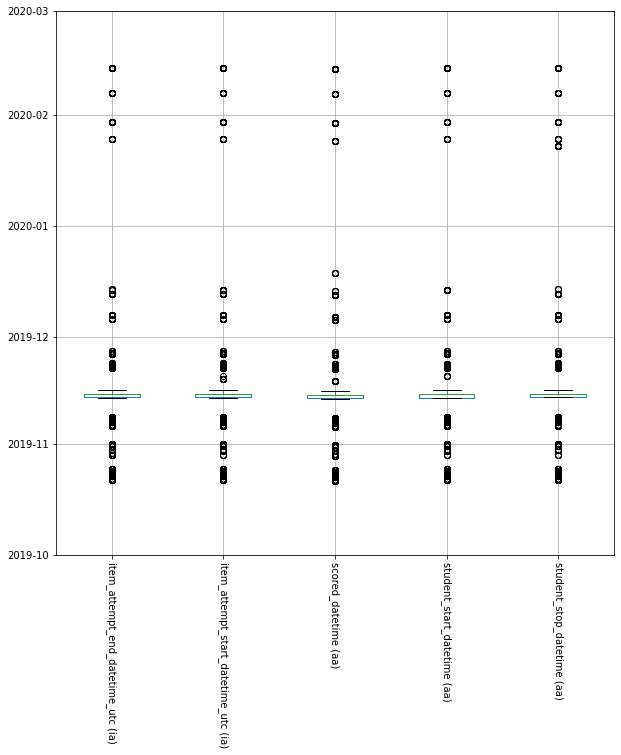

In [11]:
util.date_boxplot(outDf.select(*intVars), '')

- Median 11/15
- Majority days from 11/15
  - Could be impacted by covid

##### Conclusion
- 8% of dataset has outliers
- Appear to be irregularity due to covid
- Impute with mean

###### Test Imputation

In [13]:
util.impute_timeliness_duration(filterDf).select('timeliness_duration_mins').toPandas().describe()

,timeliness_duration_mins
count,62835.000000
mean,13204.850686
std,15651.172132
min,-2751.200000
25%,2230.983333
50%,7781.166667
75%,16441.433333
max,64108.883333


- Outliers resolved

In [14]:
util.finish_todo('Investigate timeliness durations min and max outliers')
util.add_todo('Impute timeliness durations min and max outliers')

Finished: Investigate timeliness durations min and max outliers
Todo: Impute timeliness durations min and max outliers
